# Freeswitch Log pyspark

## Altanai Bisht 
( abisht@seattleu.edu
altanai.telecom.com)

License GPL 3

In [1]:
import os 
os.environ['JAVA_HOME']="C:\\Users\\abisht\\.jdks\\corretto-11.0.15"
print(os.environ['JAVA_HOME'])

C:\Users\abisht\.jdks\corretto-11.0.15


In [2]:
import findspark
findspark.init()
findspark.find()

'C:\\Users\\abisht\\Downloads\\spark-3.2.1-bin-hadoop3.2\\spark-3.2.1-bin-hadoop3.2'

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [5]:
import pyspark 
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [6]:
from pyspark.mllib.stat import Statistics 

# 1. Call Record

FreeSWITCH CDRs stored in /usr/local/freeswitch/log/cdr-csv/Master.csv
ref : https://freeswitch.org/confluence/display/FREESWITCH/CDR
and https://freeswitch.org/confluence/display/FREESWITCH/mod_cdr_csv

In [7]:
# logfile = "/fslogs/*.log"
# fslogs = sc.textFile("hdfs://localhost:9000/"+logfile)
filepath_csv= "C:\\Users\\abisht\\FS_logs\\*.csv"

from pyspark import SparkFiles
df = spark.read.csv(SparkFiles.get(filepath_csv), header=False, inferSchema= True)

In [8]:
from datetime import datetime, date
import pandas as pd
from pyspark.sql import Row
import re

# Example Freeswitch cdr-csv log line:
# "8001","8001","0046423112856","public","2020-06-13 00:58:52","2020-06-13 00:58:52","2020-06-13 00:58:53","1","1","USER_NOT_REGISTERED","f2b05a36-ace2-11ea-aa3b-153da8caf925","","","PCMU","PCMU"
# FS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+) (\S+)" (\d{3}) (\d+)'

In [9]:
df.columns

['_c0',
 '_c1',
 '_c2',
 '_c3',
 '_c4',
 '_c5',
 '_c6',
 '_c7',
 '_c8',
 '_c9',
 '_c10',
 '_c11',
 '_c12',
 '_c13',
 '_c14']

In [10]:
parsed_df = df.select(df._c4, df._c6, df._c10)

In [11]:
parsed_df.head(2)

[Row(_c4='2020-06-13 00:58:52', _c6='2020-06-13 00:58:53', _c10='f2b05a36-ace2-11ea-aa3b-153da8caf925'),
 Row(_c4='2020-06-13 00:59:51', _c6='2020-06-13 00:59:52', _c10='15d78f5c-ace3-11ea-aa45-153da8caf925')]

In [12]:
new_rdd = parsed_df.rdd

In [13]:
from pyspark.sql import Row
parsed_rdd = new_rdd.map(lambda r : Row(\
                                        startTime =r[0],\
                                        endTime=r[1],\
                                        calluuid=r[-1]))
df2 = spark.createDataFrame(parsed_rdd)

In [15]:
# df2 = spark.createDataFrame(df)
# TypeError: data is already a DataFrame

In [16]:
df2.count()

43854

In [17]:
df2.printSchema()

root
 |-- startTime: string (nullable = true)
 |-- endTime: string (nullable = true)
 |-- calluuid: string (nullable = true)



In [18]:
df2.show(1, vertical=True)

-RECORD 0-------------------------
 startTime | 2020-06-13 00:58:52  
 endTime   | 2020-06-13 00:58:53  
 calluuid  | f2b05a36-ace2-11e... 
only showing top 1 row



In [19]:
# from pyspark.sql.functions import date_format

# df2 = df.withColumn('startTime', date_format('_c4', 'YYYY-MM-DD  HH:mm:ss'))
# df2["startTime"].show()

### Number of unique daily Callers

In [20]:
from pyspark.sql import functions as F

# find the day of the month
host_day_df = df2.select(df2['startTime'], F.dayofmonth('startTime').alias('day'))
host_day_df.show(5, truncate=False)

+-------------------+---+
|startTime          |day|
+-------------------+---+
|2020-06-13 00:58:52|13 |
|2020-06-13 00:59:51|13 |
|2020-06-13 01:00:13|13 |
|2020-06-13 01:00:36|13 |
|2020-06-13 01:00:43|13 |
+-------------------+---+
only showing top 5 rows



**host_day_distinct_df** Count of calls per day

In [21]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df = (host_day_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,NaN,21888
1,2.0,35
2,13.0,18104
3,14.0,3282
4,21.0,417
5,22.0,122
6,23.0,6


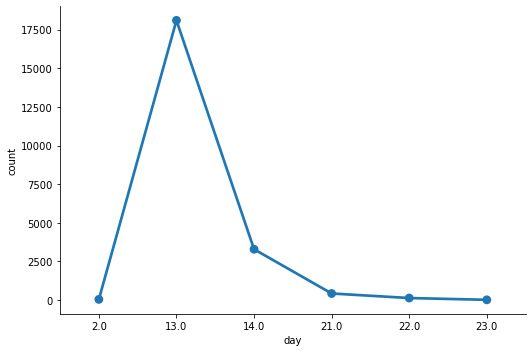

In [22]:
c = sns.catplot(x='day', y='count',
                data=daily_hosts_df,
                kind='point', height=5,
                aspect=1.5)

## Average number of daily Calls per Caller 

In [23]:
daily_hosts_df = (host_day_df
                     .groupBy('day')
                     .count()
                     .select(col("day"),col("count").alias("total_hosts")))

total_daily_reqests_df = (df
                      .select(F.dayofmonth("time").alias("day"))
                      .groupBy("day")
                      .count()
                      .select(col("day"), col("count").alias("total_reqs")))

avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

NameError: name 'col' is not defined

In [ ]:
c = sns.catplot(x='day', y='avg_reqs',
                data=avg_daily_reqests_per_host_df,
                kind='point', height=5, aspect=1.5)

## Aggregate

In [ ]:
(df.agg(F.min(df['_c7']).alias('min_content_size'),
            F.max(df['_c7']).alias('max_content_size'),
            F.mean(df['_c7']).alias('mean_content_size'),
            F.stddev(df['_c7']).alias('std_content_size'),
            F.count(df['_c7']).alias('count_content_size'))
        .toPandas())

## Call Hangup/status code analysis

In [ ]:
status_freq_df = (df.groupBy('_c9')
                     .count()
                     .sort('_c9')
                     .cache())
print('Total distinct HTTP Status Codes:', status_freq_df.count())   

In [ ]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

In [ ]:
# import matplotlib.pylab as plt
sns.catplot(x='_c9', y='count', data=status_freq_pd_df,
            kind='bar',
            order=status_freq_pd_df['_c9'])
plt.xticks(rotation=45)

# 3. Counting NORMAL_CLEARING response codes

In [ ]:
normal_clearing_df = df.filter(df["_c9"] == 'NORMAL_CLEARING').cache()
print(('Total NORMAL_CLEARING hangupcode: {}').format(normal_clearing_df.count()))

In [ ]:
# Top 20 normal clearings
normal_clearing_count_df = (normal_clearing_df
                          .groupBy("_c1")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

normal_clearing_count_df.show(truncate=False)

## Hourly normal clearings

In [ ]:
hourly_avg_normal_clearing_df = (normal_clearing_df
                                   .groupBy(F.hour('_c4').alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_normal_clearing_pd_df = hourly_avg_normal_clearing_df.toPandas()

c = sns.catplot(x='hour', y='count',
                data=hourly_avg_normal_clearing_pd_df,
                kind='bar', height=5, aspect=1.5)

##   Caller / Call Destinations

In [ ]:
host_sum_df =(df
               .groupBy('_c2')
               .count()
               .sort('count', ascending=False).limit(10))

host_sum_df.show(truncate=False)

# 4 Call duration per hour 

In [ ]:
callduration_df = df.filter(df["_c7"] > 0).cache()
print(('Total Calls with non zero Duration is {}').format(callduration_df.count()))

In [ ]:
callduration_df.toPandas().plot()

In [ ]:
hourly_callduration_df = (callduration_df
                                   .groupBy(F.hour('_c4').alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_callduration_pd_df = hourly_callduration_df.toPandas()

c = sns.catplot(x='hour', y='count',
                data=hourly_callduration_pd_df,
                kind='bar', height=5, aspect=1.5)

In [ ]:
host_sum_pd_df = host_sum_df.toPandas()
host_sum_pd_df.iloc[8]['_c2']

# Carbon Footprint

In [ ]:
import carbonfootprint as carbonfp
# from carbonfp.power_utilities.carbon import Carbon
# from power_utilities.fuelmix import Fuelmix
# # from power_utilities.Fuelmix import calculate_fuelmixbypercent
# # from power_utilities import carbon_by_fuelmix
# from power_utilities import fuelmix

In [ ]:
carbonfp

In [ ]:
# for importer, modname, ispkg in carbonfp(path=None, onerror=lambda x: None):
#     print(modname)

for importer, modname, ispkg in carbonfp.iter_modules(package.__path__):
    print("Found submodule %s (is a package: %s)" % (modname, ispkg))

In [ ]:
furlpercent_obj = carbonfp.power_utilities.Fuelmix("north_west")

In [ ]:

dfindus_hourly_fuelmix = furlpercent_obj.calculate_fuelmixbypercent(dfindus_hourly)
carbonemissio_pbj = Carbon()
dfindus_hourly_fuelmix_carbon = carbonemissio_pbj.calculate_carbonemission(dfindus_hourly_fuelmix)
print("-------------dfindus_hourly_fuelmix_carbon------------------")
print(dfindus_hourly_fuelmix_carbon.head())
print(dfindus_hourly_fuelmix_carbon.columns)


**Refs**
- https://opensource.com/article/19/5/visualize-log-data-apache-spark